In [ ]:
import torch
import cv2
import numpy as np
import os
import glob as glob

from xml.etree import ElementTree as et
from config import (
    CLASSES, RESIZE_TO, 
    TRAIN_DIR_IMAGES, VALID_DIR_IMAGES, 
    TRAIN_DIR_LABELS, VALID_DIR_LABELS,
    BATCH_SIZE
)
from torch.utils.data import Dataset, DataLoader
from custom_utils import collate_fn, get_train_transform, get_valid_transform

In [ ]:
import ast, json

In [ ]:
def read_dicts_from_file(file_path):
    lines = []
    with open(file_path, 'r') as file:
        lines = file.readlines()

    dictionary = ''
    for line in lines:
        line = line.replace('\n','').split(' ')
        line = [s for s in line if len(s) != 0]
        for s in line:
            dictionary = dictionary + s
            
    return ast.literal_eval(dictionary)

# Example usage
file_path = './input/train_txts/000032.txt'
dictionaries = read_dicts_from_file(file_path)

# Now 'dictionaries' is a list containing dictionaries from the file
print(dictionaries)

In [ ]:
class CustomDataset(Dataset):
    def __init__(
        self, images_path, labels_path, 
        width, height, classes, transforms=None
    ):
        self.transforms = transforms
        self.images_path = images_path
        self.labels_path = labels_path
        self.height = height
        self.width = width
        self.classes = classes
        self.image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm']
        self.all_image_paths = []
        self.dictionary = dict()
        
        # get all the image paths in sorted order
        for file_type in self.image_file_types:
            self.all_image_paths.extend(glob.glob(f"{self.images_path}/{file_type}"))
        self.all_annot_paths = glob.glob(f"{self.labels_path}/*.txt")
        
        # Remove all annotations and images when no object is present.
        self.read_and_clean()
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths]
        self.all_images = sorted(self.all_images)
    
    def read_and_clean(self):
        """
        This function will discard any images and labels when the XML 
        file does not contain any object.
        """
        for annot_path in self.all_annot_paths:

            self.dictionary = read_dicts_from_file(annot_path)
            bbox = self.dictionary['bboxes']
            
            if len(bbox) == 0:
                print(f"Removing {annot_path} and corresponding image")
                self.all_annot_paths.remove(annot_path)
                self.all_image_paths.remove(annot_path.split('.txt')[0]+'.jpg')

    def __getitem__(self, idx):
        
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.images_path, image_name)

        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.labels_path, annot_filename)
        
        boxes = []
        labels = []
        # tree = et.parse(annot_file_path)
        # root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]

        dictionary = read_dicts_from_file(annot_file_path)
        bboxes = dictionary['bboxes']
        labels = dictionary['pedestrian_class']
        
        # box coordinates for xml files are extracted and corrected for image size given
        # for member in root.findall('object'):
        for bbox, label in zip(bboxes, labels):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            bbox_ = bbox
            labels.append(label)
          
            
            # xmin = left corner x-coordinates
            xmin = bbox_[0][0]
            # xmax = right corner x-coordinates
            xmax = bbox_[1][0]
            # ymin = left corner y-coordinates
            ymin = bbox_[0][1]
            # ymax = right corner y-coordinates
            ymax = bbox_[1][1]
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image=image_resized,
                                     bboxes=target['boxes'],
                                     labels=labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# prepare the final datasets and data loaders
def create_train_dataset():
    train_dataset = CustomDataset(
        TRAIN_DIR_IMAGES, TRAIN_DIR_LABELS,
        RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
    )
    return train_dataset
def create_valid_dataset():
    valid_dataset = CustomDataset(
        VALID_DIR_IMAGES, VALID_DIR_LABELS, 
        RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
    )
    return valid_dataset

def create_train_loader(train_dataset, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=0):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return valid_loader

In [ ]:
dataset = CustomDataset(
    TRAIN_DIR_IMAGES, TRAIN_DIR_LABELS, RESIZE_TO, RESIZE_TO, CLASSES
)
print(f"Number of training images: {len(dataset)}")

# function to visualize a single sample
def visualize_sample(image, target):
    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = 'Pedestrian'#CLASSES[target['labels'][box_num]]
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 2
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
    cv2.imshow('Image', image)
    cv2.waitKey(0)
    
NUM_SAMPLES_TO_VISUALIZE = 20
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    visualize_sample(image, target)

# Spliting the dataset

In [ ]:
import os
import random
import shutil

In [ ]:
dataset_path = './input/Dataset/'
destination_folder_80_images = './input/train_images/'
destination_folder_80_text = './input/train_txts/'
destination_folder_10_val_images = './input/valid_images/'
destination_folder_10_val_text = './input/valid_txts/'

In [ ]:
files_txt = os.listdir(dataset_path + "out_bbox")
files_img = os.listdir(dataset_path + "out_rgb")

In [ ]:
random.shuffle(files_txt)
random.shuffle(files_img)

In [ ]:
total_files = len(files_txt)
split_80 = int(0.8*total_files)
split_20 = total_files - split_80

In [ ]:
files_80 = files_txt[:split_80]
files_20 = files_txt[split_80:]

In [ ]:
files_txt_80 = files_80
files_txt_20 = files_20

In [ ]:
files_without_extensions_80 = [os.path.splitext(file)[0] for file in files_80]
files_without_extensions_20 = [os.path.splitext(file)[0] for file in files_20]

In [ ]:
def move_files(file_list, original_folder_path, destination_folder):
    for file in file_list:
        file = file+'.png'
        source_path = os.path.join(original_folder_path, file)
        destination_path = os.path.join(destination_folder, file)
        shutil.move(source_path, destination_path)

In [ ]:
move_files(files_without_extensions_20, './input/Dataset/out_rgb/', destination_folder_10_val_images)

In [ ]:
folder_path_1 = './input/Dataset/out_bbox'
folder_path_2 = './input/Dataset/out_rgb'

In [ ]:
def get_files_without_extension(folder_path):
    return set(os.path.splitext(file)[0] for file in os.listdir(folder_path))

In [ ]:
def compare_folders(folder_path1, folder_path2):
    files1 = get_files_without_extension(folder_path1)
    files2 = get_files_without_extension(folder_path2)

    common_files = files1.intersection(files2)

    if common_files:
        print("Common files without extensions:")
        print(len(common_files))
    else:
        print("No common files without extensions.")

In [ ]:
compare_folders(folder_path_1, folder_path_2)

Move images back to rgb folder

In [ ]:
import ast

In [ ]:
files_txt = os.listdir('./input/valid_txts/')

In [ ]:
def read_dicts_from_file(file):
    file_path='./input/valid_txts/'+file
    lines = []
    with open(file_path, 'r') as file:
        lines = file.readlines()

    dictionary = ''
    for line in lines:
        line = line.replace('\n','').split(' ')
        line = [s for s in line if len(s) != 0]
        for s in line:
            dictionary = dictionary + s
            
    return ast.literal_eval(dictionary)

In [ ]:
def read_and_clean(files_txt):
        """
        This function will discard any images and labels when the .txt 
        file does not contain any object.
        """

        for file in files_txt:
            
            dictionary = read_dicts_from_file(file)
            bbox = dictionary['bboxes']
            label = dictionary['pedestrian_class']

            if len(bbox) == 0 or len(label) == 0:
              

                shutil.move('./input/valid_txts/'+file, './input/Dataset/out_bbox/'+file)
                shutil.move('./input/valid_images/'+file.split('.')[0]+'.png', './input/Dataset/out_rgb/'+file.split('.')[0]+'.png')
            

In [ ]:
read_and_clean(files_txt)

CHANGED PEDESTRIAN 9 TO 1

In [ ]:
def read_dicts_from_file(file_path):
    lines = []
    with open(file_path, 'r') as file:
        lines = file.readlines()

    dictionary = ''
    for line in lines:
        line = line.replace('\n','').split(' ')
        line = [s for s in line if len(s) != 0]
        for s in line:
            dictionary = dictionary + s
            
    return ast.literal_eval(dictionary)

In [ ]:
files_txt = os.listdir('./input/train_txts/')

In [ ]:
path = './input/train_txts/'

In [ ]:
for file in files_txt:
    full_path = path + file

    dict = read_dicts_from_file(full_path)

    print(dict)
    

In [ ]:
import json

def replace_values_in_json_file(file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Replace the value 9 with 1 in the "pedestrian_class" key
    if "pedestrian_class" in data:
        data["pedestrian_class"] = [1 if val == 9 else val for val in data["pedestrian_class"]]

    # Write the updated content back to the file
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

In [ ]:
import os

def replace_values_in_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):  # Assuming your JSON files have a .txt extension
            file_path = os.path.join(directory_path, filename)
            replace_values_in_json_file(file_path)

# Example: Replace values in all .txt files in the current directory
replace_values_in_directory('./input/test_txts/')


In [ ]:
from collections import defaultdict
import json
import numpy as np

class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
            
        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]
    def load_imgs(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        print(im_ids)
        return [self.annIm_dict[ann_id] for ann_id in im_ids]       
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]


In [ ]:
coco_annotations_file="./output.json"
coco_images_dir="./input/train_images"
coco= COCOParser(coco_annotations_file, coco_images_dir)

In [ ]:
ids = coco.get_imgIds()

In [ ]:
len(ids)

In [ ]:
for i in ids:
    print(i)
    
from PIL import Image
import numpy as np
ann_ids = coco.get_annIds(i)
print(ann_ids)

In [ ]:

from PIL import Image
import numpy as np
num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:numcoco.loadImgs(img_id)[0]['file_name']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()

for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/12_18_" + im +".png")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')

        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)
    

    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')

plt.tight_layout()
plt.show()

006112
tensor([[587.7879, 313.8516, 608.1252, 378.3207],
        [201.5023, 307.0174, 210.8031, 337.1378],
        [325.1859, 306.9341, 332.2539, 337.5794],
        [480.0119, 306.7119, 487.4515, 338.0305],
        [550.8771, 307.0734, 559.5975, 339.4916],
        [147.1043, 306.8159, 156.7263, 338.0880]], device='cuda:0') tensor([1.0000, 0.9997, 0.9996, 0.9978, 0.9054, 0.2809], device='cuda:0')


/tmp/ipykernel_1084065/3687086963.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img*255, dtype=torch.uint8)


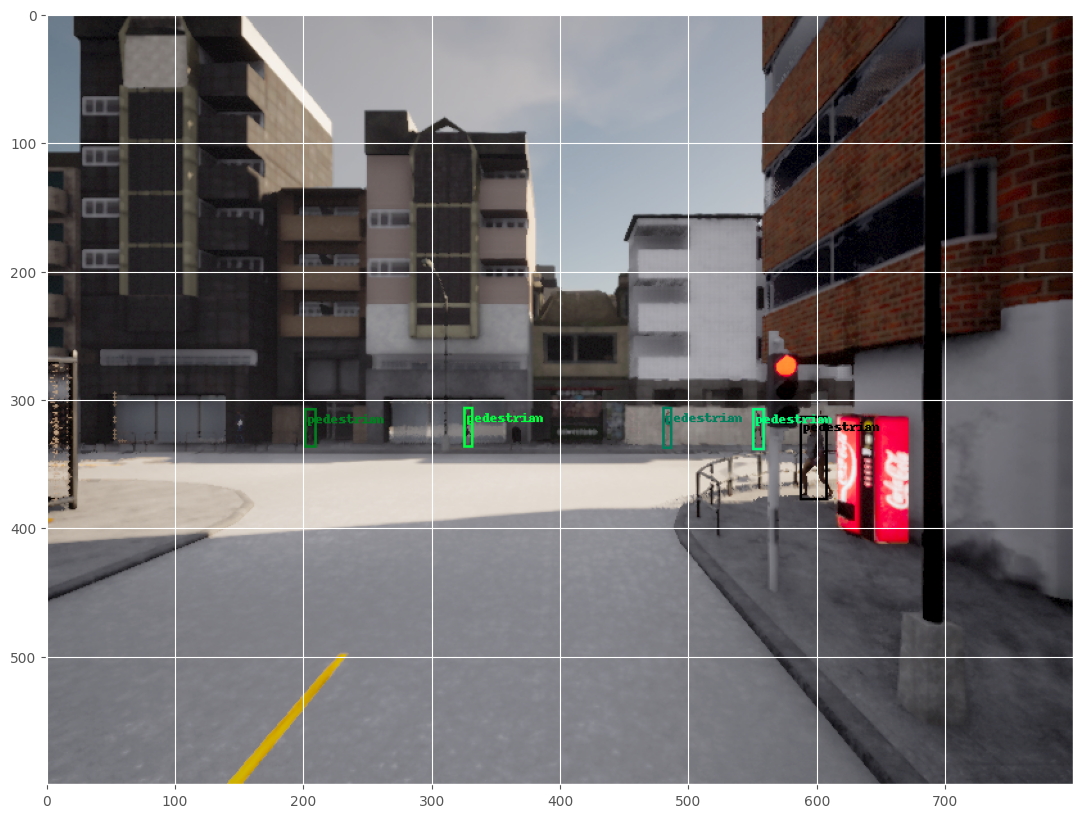

In [356]:
from torchvision.utils import draw_bounding_boxes
import torch

from dataset_dev import (
    create_train_dataset, create_valid_dataset,
    create_train_loader, create_valid_loader,
    create_test_dataset
)

from config import (
    DEVICE, NUM_CLASSES,
    NUM_EPOCHS, NUM_WORKERS,
    OUT_DIR, VISUALIZE_TRANSFORMED_IMAGES
)

import matplotlib.pyplot as plt 
from models.fasterrcnn_resnet18 import create_model


classes = ['background', 'pedestrian']

# Code for importing model
model = create_model(num_classes=NUM_CLASSES)

checkpoint = torch.load('./outputs/ResNet18_scratch_with_pretrained_weights_RL.pth')
# checkpoint = torch.load('./outputs/ResNet18_scratch_without_pretrained.pth')

model.load_state_dict(checkpoint['model_state_dict'])

##########################

model.eval()
model.to(DEVICE)
torch.cuda.empty_cache()

test_dataset = create_test_dataset()

print(test_dataset.ids[304])

img, _ = test_dataset[304]
img_int = torch.tensor(img*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img.to(DEVICE)])
    pred = prediction[0]

fig = plt.figure(figsize=(14, 10))

print(pred['boxes'], pred['scores'])

plt.imshow(draw_bounding_boxes(img_int, 
                               pred['boxes'][pred['scores']>0.8],
                               [classes[i] for i in pred['labels'][pred['scores']>0.8].tolist()], 
                               width=2).permute(1, 2, 0)
                        )

In [ ]:
ned.pth')

model.load_state_dict(checkpoint['model_state_dict'])

##########################

model.eval()
model.to(DEVICE)
torch.cuda.empty_cache()

test_dataset = create_test_dataset()

print(test_dataset.ids[91])

img, _ = test_dataset[91]
img_int = torch.tensor(img*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img.to(DEVICE)])
    pred = prediction[0]

fig = plt.figure(figsize=(14, 10))

print(pred['boxes'], pred['scores'])

plt.imshow(draw_bounding_boxes(img_int, 
                               pred['boxes'][pred['scores']>0.8],
                               [classes[i] for i in pred['labels'][pred['scores']>0.8].tolist()], 
                               width=2).permute(1, 2, 0)
                        )

To rename the files in the folder

In [ ]:
import os

# Set the prefix
prefix = "12_18_"

# Set the path to your folder
folder_path = "./input/test_txts/"

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    # Check if it's a file (not a directory)
    if os.path.isfile(os.path.join(folder_path, filename)):
        # Add the prefix to the file name
        new_name = prefix + filename

        # Rename the file
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_name))

        print(f"Renamed: {filename} to {new_name}")
